# Classifying waste products using Transfer Learning

Adrian P. Bustamante, Ph.D.

adrianpebus@gmail.com

### __Table of Contents__

<ol>
    <li><a href="#1.-Objective">Objective</a></li>
    <li><a href="#2.-About-the-data">About the dataset</a></li>
    <li><a href="#3.-Data-Preparation">Data Preparation</a></li>
    <li><a href="#4.-Transfer-learning-with-VGG-16">Transfer learning with VGG-16</a></li>
    <li><a href="#5.-Fine-tuning-the-model">Fine-tuning the model</a></li>
    <li><a href="#6.-Evaluating-the-models">Evaluating the models</a></li>
</ol>

## 1. Objective

The aim of the project is to develop an automated waste classification model that can accurately differentiate between recyclable and organic waste based on images. The project will use transfer learning, and fine-tuning, with a pre-trained VGG16 model to classify images.

## 2. About the data

Dataset is divided into train data (85%) and test data (15%)  
Dataset is divided into two classes R (recyclable) and O (organic)

Training data - 22564 images  Test data - 2513 images

The dataset can be found at https://www.kaggle.com/datasets/techsash/waste-classification-data/data

## 3. Data Preparation

##### Importing libraries and downloading the data

In [2]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt
import glob, os, pathlib
from matplotlib.image import imread
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

os.environ['TF_CPP-MIN_LOG_LEVEL'] = '3'
plt.style.use('dark_background')

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

#print("Path to dataset files:", path)

/home/adrian/Documents/ibm-certifications/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_dir = path + '/DATASET/TRAIN'
test_dir = path + '/DATASET/TEST'

print('------------ Training -------------')
data_dir_train = pathlib.Path(train_dir)
for folder in data_dir_train.glob('*'):
    print(f'The folder {folder.name} has {len(list(folder.glob('*.jpg')))} pictures')
image_count = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count, 'total training images')

print('------------ Test -------------')
data_dir_test = pathlib.Path(test_dir)
for folder in data_dir_test.glob('*'):
    print(f'The folder {folder.name} has {len(list(folder.glob('*.jpg')))} pictures')
image_count = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count, 'total testing images')

------------ Training -------------
The folder R has 9999 pictures
The folder O has 12565 pictures
22564 total training images
------------ Test -------------
The folder R has 1112 pictures
The folder O has 1401 pictures
2513 total testing images


##### Configuration options

In [5]:
#### Configuration options
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 20
n_classes = 2
val_split = 0.2
verbosity = 1
path = train_dir
path_test = test_dir
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

##### Train, validation, and test sets

In [6]:
# Create ImageDataGenerators for training and validation and testing
## augmenting images
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [7]:
## traiqn, validation, and test sets

train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    class_mode='binary',
    seed=seed,
    batch_size=batch_size,
    shuffle=True,
    target_size=(img_rows, img_cols)
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


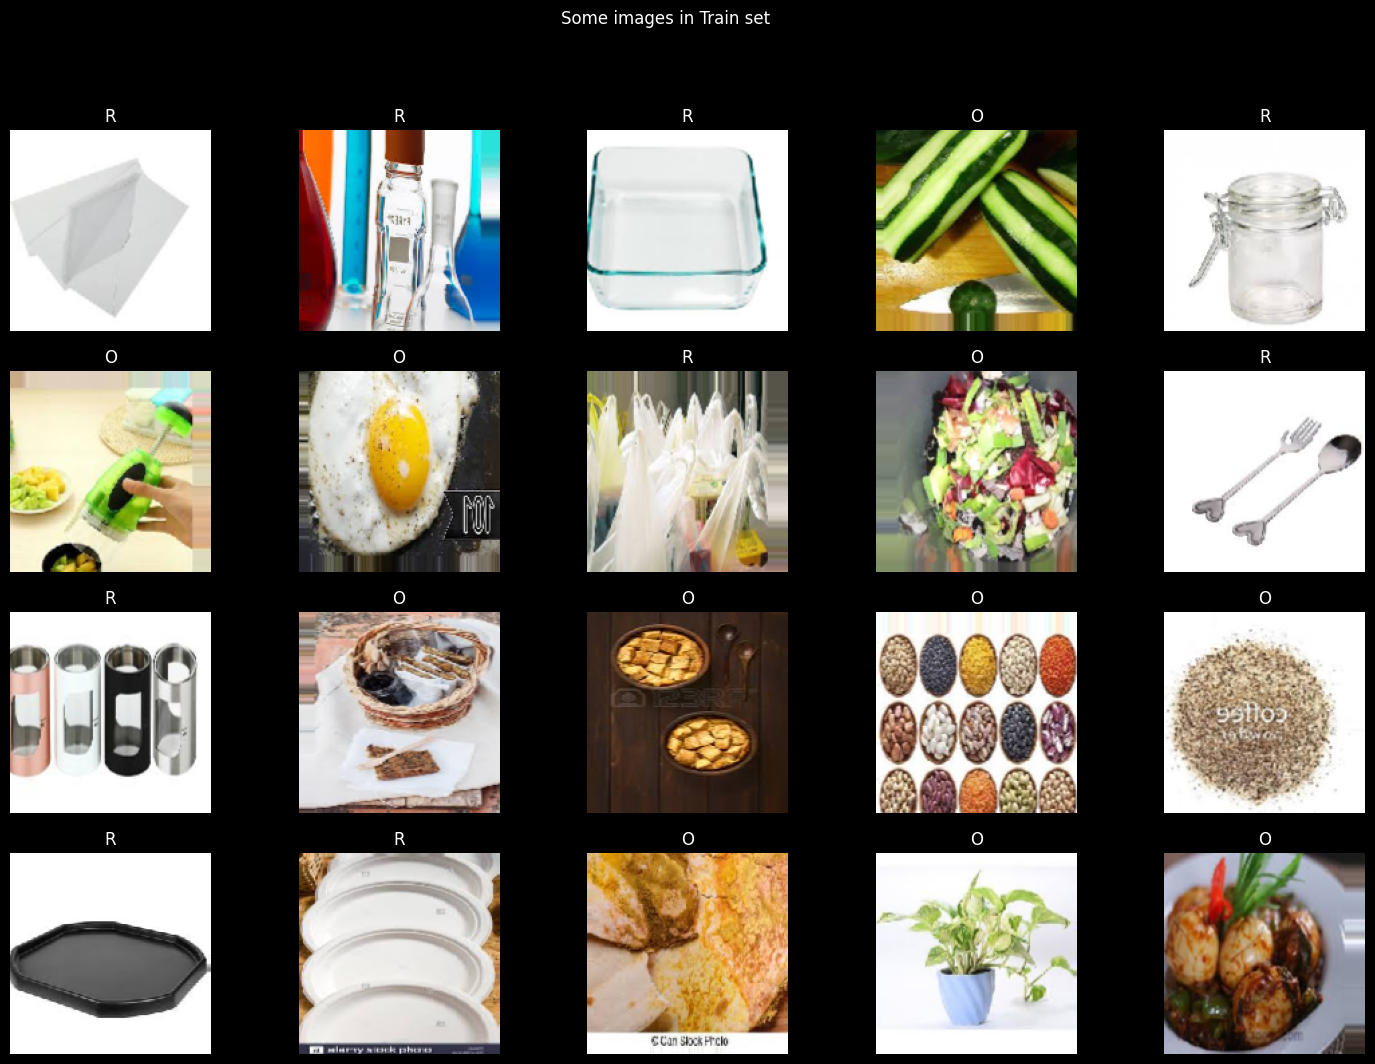

In [8]:
###visualizing some images in the train set
class_names = list(train_generator.class_indices.keys())

first_batch = train_generator[4]
plt.figure(figsize=(18,12))
plt.suptitle('Some images in Train set')
for i in np.arange(20):
    plt.subplot(4,5, i+1)
    plt.imshow(first_batch[0][i])
    plt.title(class_names[int(first_batch[1][i])])
    plt.axis('off')

## 4. Transfer learning with VGG-16

In [9]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

### flatten last layer and set layers to not-trainable
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)

basemodel = Model(vgg.input, output)
for layer in basemodel.layers: 
    layer.trainable = False

2025-04-16 00:06:16.847440: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
## final layers
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
##compiling the model
model.compile(loss='binary_crossentropy',
              optimizer= optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy']
             )

In [12]:
###callbacks
from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_vgg16.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-3
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
    EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

In [13]:
extract_feat_model = model.fit(train_generator, 
                               steps_per_epoch=20, 
                               epochs=25,
                               callbacks = callbacks_list_,   
                               validation_data=val_generator, 
                               #validation_steps=val_generator.samples // batch_size, 
                               validation_steps = 15,
                               verbose=1)

/home/adrian/Documents/ibm-certifications/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5686 - loss: 2.2162lr: 0.0009048374180359595
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.5725 - loss: 2.1724 - val_accuracy: 0.8104 - val_loss: 0.4896 - learning_rate: 0.0010
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7654 - loss: 0.4731lr: 0.0008187307530779819
20/20 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step - accuracy: 0.7650 - loss: 0.4751 - val_accuracy: 0.8417 - val_loss: 0.4019 - learning_rate: 9.0484e-04
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7801 - loss: 0.4946lr: 0.0007408182206817179
20/20 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step - accuracy: 0.7808 - loss: 0.4929 - val_accuracy: 0.8125 - val_loss: 0.3954 - learning_rate: 8.1873e-04
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7834 - loss: 0.4710lr: 0.0006703200460356392
20/20 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.7833 - loss: 0.4708 - val_accuracy: 0.8708 - val_loss: 0.3164 - learning_rate: 7.4082e

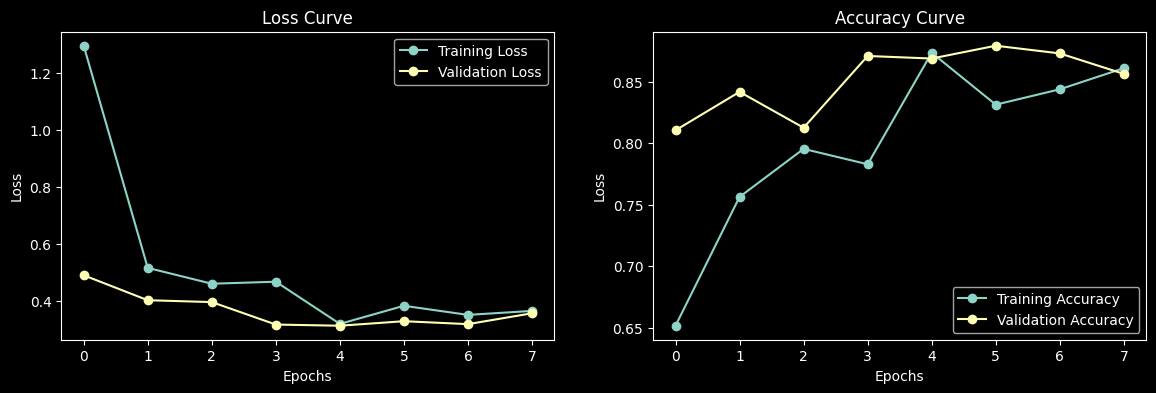

In [14]:
import matplotlib.pyplot as plt

history = extract_feat_model

fig = plt.figure(figsize=(14,4))

# plot loss curve
ax = fig.add_subplot(1,2,1)
#plt.figure(figsize=(5, 5))
ax.plot(history.history['loss'], label='Training Loss', marker='o')
ax.plot(history.history['val_loss'], label='Validation Loss', marker='o')
ax.set_title('Loss Curve')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
#plt.show()

ax = fig.add_subplot(1,2,2)
#plt.figure(figsize=(5,5))
ax.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
ax.set_title('Accuracy Curve')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()


## 5. Fine-tuning the model

In [15]:
display([layer.name for layer in basemodel.layers])

['input_layer',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten']

In [16]:
set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv2']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

model.summary()

input_layer: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: True
block5_conv3: True
block5_pool: True
flatten: True


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,630,660 (90.14 MB)

 Trainable params: 9,177,601 (35.01 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

 Optimizer params: 4,457,987 (17.01 MB)

In [17]:
checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

#checkpoint_path='bt_customed_mobilenet_notune.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8),
             tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min'),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=3,verbose=1,mode="auto",
                                                  min_delta=0.001,cooldown=0,min_lr=0.0)
            ]


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator, 
                            steps_per_epoch=20, 
                            epochs=25,
                            callbacks = callbacks,
                            validation_data=val_generator,
                            validation_steps = 15,
                            #validation_steps=val_generator.samples // batch_size, 
                            verbose=1)

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.8345 - loss: 0.4951 - val_accuracy: 0.8542 - val_loss: 0.3449 - learning_rate: 1.0000e-04
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.8620 - loss: 0.3293 - val_accuracy: 0.8354 - val_loss: 0.4022 - learning_rate: 1.0000e-04
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.8584 - loss: 0.3218 - val_accuracy: 0.8396 - val_loss: 0.4513 - learning_rate: 1.0000e-04
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8718 - loss: 0.2868
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.8722 - loss: 0.2875 - val_accuracy: 0.8458 - val_loss: 0.4083 - learning_rate: 1.0000e-04
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.9026 - loss: 0.2480 - val_accuracy: 0.8833 - val_loss: 0.3453 - learning_rate: 1.0000e-05
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 109s 6s/step - accuracy: 0.8908 - loss:

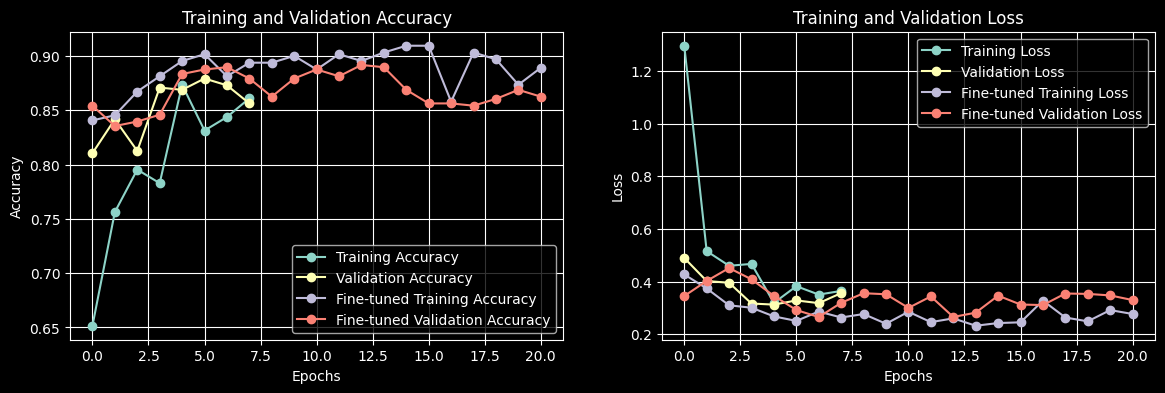

In [18]:
# Plot accuracy and loss curves
history_fine = fine_tune_model

fig = plt.figure(figsize=(14,4))

ax = fig.add_subplot(1,2,1)
ax.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy',marker='o')
ax.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy', marker='o')
ax.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy', marker='o')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Training and Validation Accuracy')
plt.grid(True)
#plt.show()

ax = fig.add_subplot(1,2,2)
ax.plot(history.history['loss'], label='Training Loss', marker='o')
ax.plot(history.history['val_loss'], label='Validation Loss', marker='o')
ax.plot(history_fine.history['loss'], label='Fine-tuned Training Loss', marker='o')
ax.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss', marker='o')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Training and Validation Loss')
plt.grid(True)
#plt.show()

## 6. Evaluating the models

In [19]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob(test_dir + '/O/*')
test_files_R = glob.glob(test_dir + '/R/*')
#test_files #= test_files_O[:50] + test_files_R[:50]
test_files = test_files_O + test_files_R

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Extract Features Model
              precision    recall  f1-score   support

           O       0.86      0.91      0.88      1401
           R       0.88      0.80      0.84      1112

    accuracy                           0.87      2513
   macro avg       0.87      0.86      0.86      2513
weighted avg       0.87      0.87      0.86      2513

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.85      0.94      0.89      1401
           R       0.91      0.78      0.84      1112

    accuracy                           0.87      2513
   macro avg       0.88      0.86      0.87      2513
weighted avg       0.88      0.87      0.87      2513



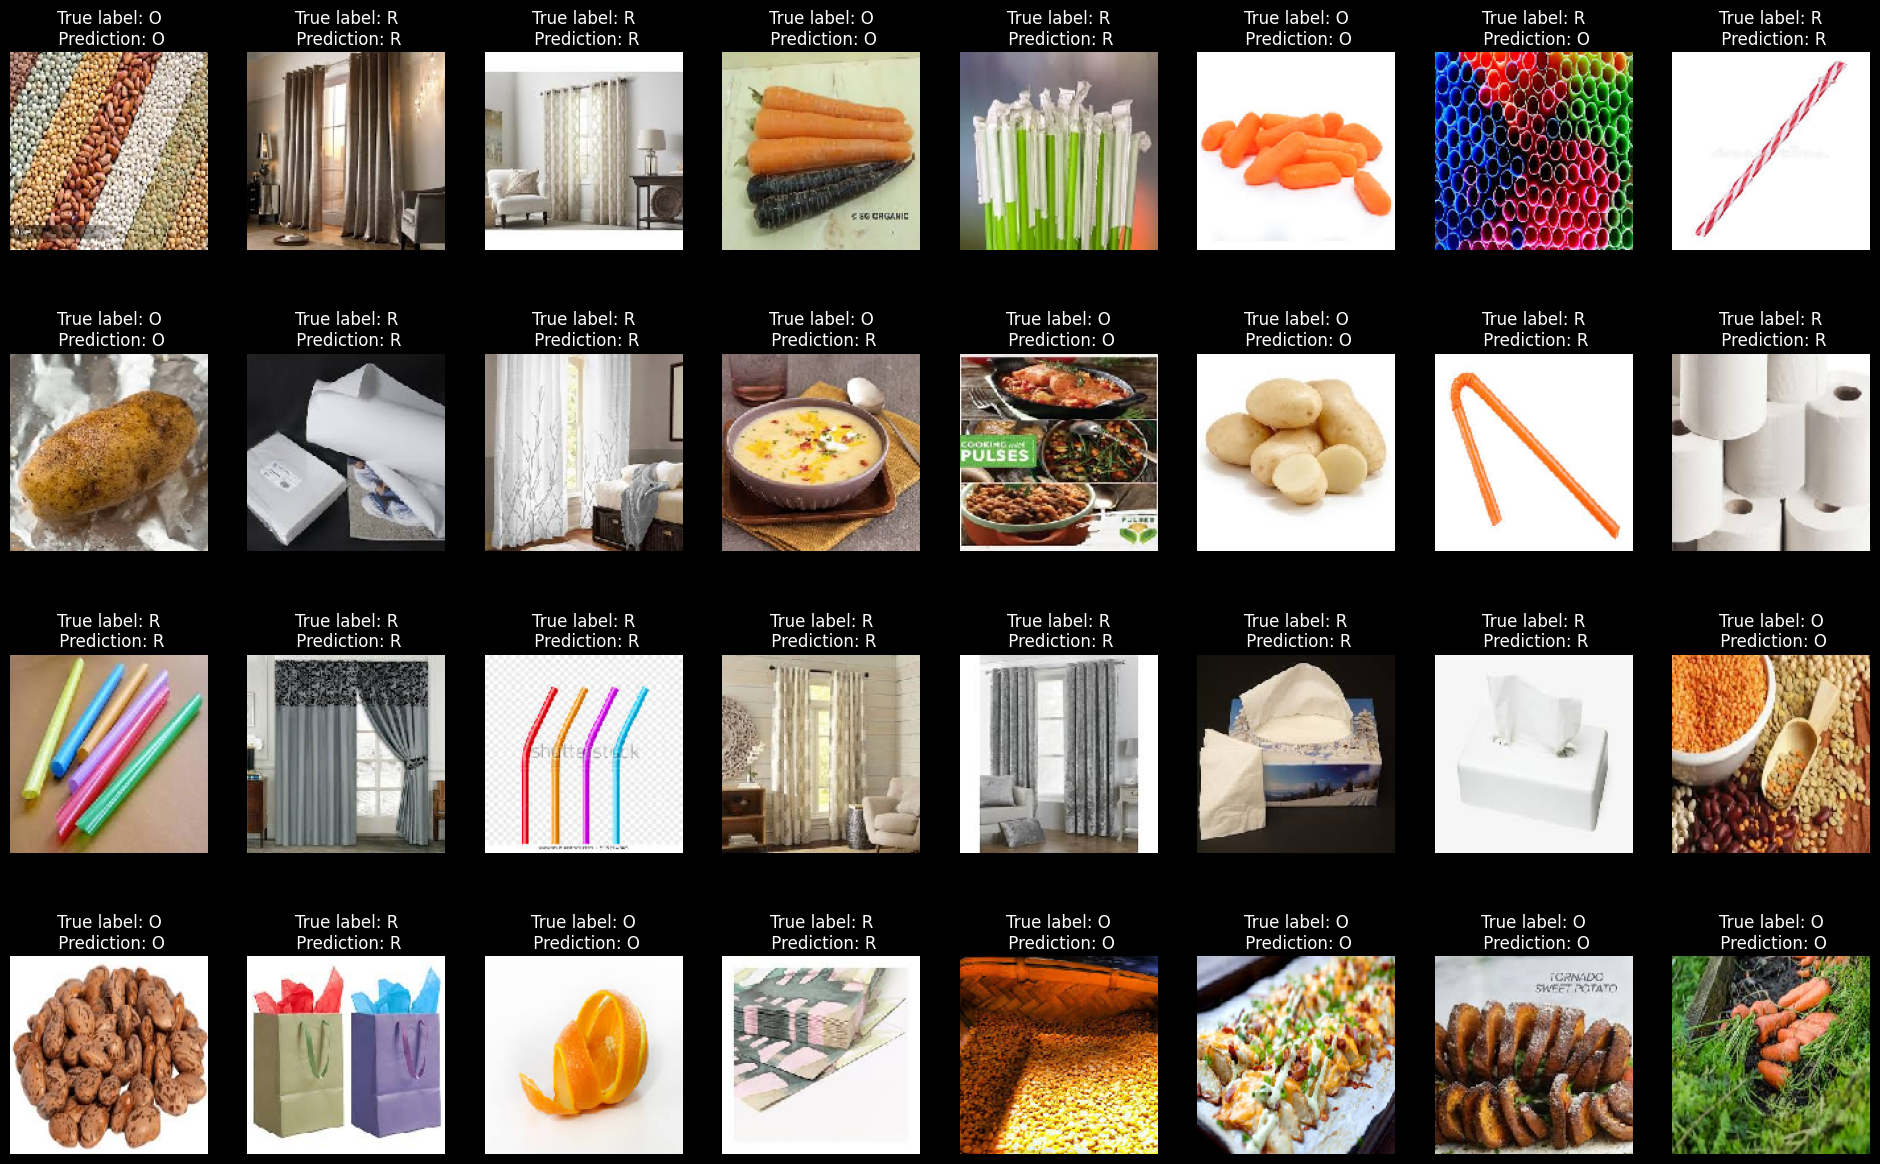

In [20]:
test_batch = test_generator[6]

plt.figure(figsize=(24,15))
for i in np.arange(32):###batch needs to have at least number of images to plot
    plt.subplot(4,8, i+1)
    plt.imshow(test_batch[0][i])
    pred = fine_tune_model.predict(test_batch[0][i].reshape(1, img_rows, img_cols, 3), verbose=0)[0][0]
    if pred < 0.5:
        pred = 0
    else:
        pred = 1
    plt.title(f'True label: {class_names[int(test_batch[1][i])]}\n Prediction: { class_names[pred]}' )
    plt.axis('off')
